# Figure 2

This figure shows how the models compare to one paleoclimate reconstruction (PCR) over the last millennium.

In [1]:
# import the necessary libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from scipy import signal
from scipy import stats
from scipy.stats import linregress
from scipy.signal import detrend
import scipy.signal as signal
from statsmodels.api import tsa
import xarray as xr
import warnings
import zarr

# style guide for plots
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
mpl.rcParams['font.size'] = 12

def compute_cox(x):
    x = x[~np.isnan(x)]
    psi_vals=[]
    for i in np.arange(0, len(x)-55):
        y = signal.detrend(x[i:i+55])
        auto_m1 = tsa.acf(y,nlags=1) # autocorrelation function from statsmodels
        auto_m1b = auto_m1[1]    # select 1 lag autocorrelation value
        sigma_m1= np.std(y)
        log_m1= np.log(auto_m1b)
        log_m1b = np.abs(log_m1)   # take absolute value
        sqrt_m1 = np.sqrt(log_m1b)
        psi = sigma_m1/sqrt_m1
        psi_vals.append(psi)
    return np.nanmean(psi_vals)

def compute_nijsse(x, length=10):
    # remove NaNs from the timeseries
    x = np.array(x)
    mask = ~np.isnan(x)
    x = x[mask]
    # fill it with slopes
    slopes = []
    i = 0
    while i < len(x)-length:
        slope, intercept, r, p, se = linregress(np.arange(0,length), x[i:i+length])
        slopes.append(length*slope)
        i+=length
    return np.nanstd(slopes)

In [2]:
from pathlib import Path
import os
notebooks_dir = Path(os.path.abspath('__file__')).parent.parent
data_dir = notebooks_dir.parent / 'data'

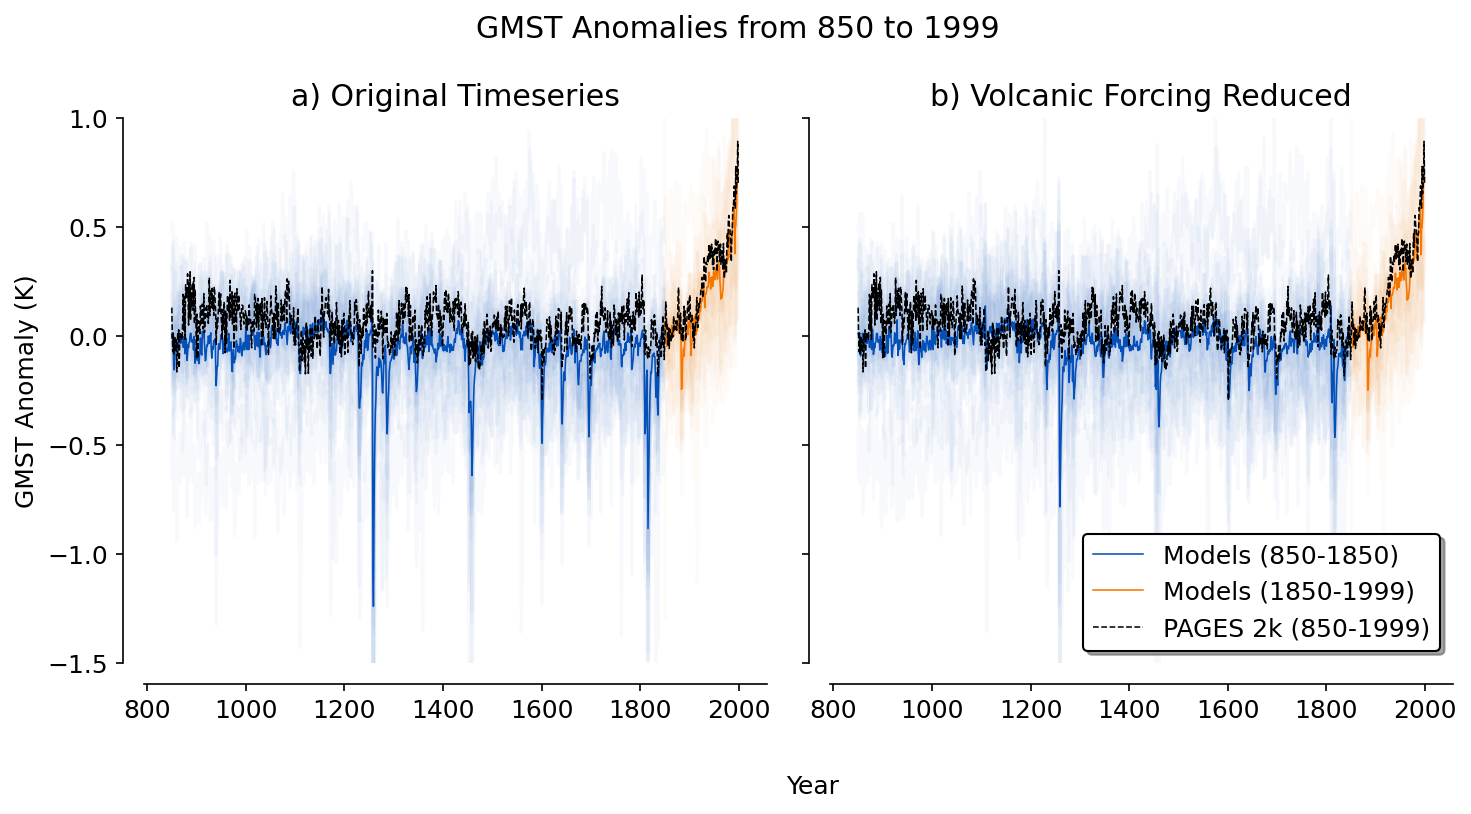

In [3]:
# read in the timeseries dataframe
timeseries_df = pd.read_csv(data_dir/'ts.csv').drop('Unnamed: 0', axis=1)

# the columns of the dataframe are the model names
model_names = timeseries_df.columns[1:]

# the ecs values 
ecs_values = pd.read_csv(data_dir/'ecs.csv')

# years
years = timeseries_df['year']

def anomaly_ts(model):
    '''
    function: takes the GMST timeseries and computes the anomaly relative to the 1850-1870 climatology
    inputs: model, the model name, str
    outputs: the GMST anomaly timeseries in units K, List[float]
    '''
    # get the model-specific GMST timseries
    ts = timeseries_df[model]
    # compute the reference temperature from the 1850-1870 climatology
    ref = np.mean(ts[990:1010])
    # return the anomaly
    return ts - ref

historical_color = '#F57600'
past1000_color = '#054FB9'

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].set_ylim((-1.5, 1))

# plot the temperature anomalies for each model
for model in model_names:
    ax[0].plot(years[:1000], anomaly_ts(model)[:1000], color = past1000_color, alpha = 0.03)
    ax[0].plot(years[1000:], anomaly_ts(model)[1000:], color = historical_color, alpha = 0.03)

# plot the multi-model mean temperature anomaly
model_mean = timeseries_df[model_names].mean(axis=1)
model_mean_ref = np.mean(model_mean[990:1010])
ax[0].plot(years[:1000], (model_mean - model_mean_ref)[:1000], color = past1000_color, linewidth = 0.75, label = 'Models (850-1850)')
ax[0].plot(years[1000:], (model_mean - model_mean_ref)[1000:], color = historical_color, linewidth = 0.75, label = 'Models (1850-2000)')

# now, do the same with the PCR reconstruction from PAGES 2k
pcr_data = pd.read_csv(data_dir/'pages_2k/PCR.txt', delimiter = '\t')[849:-1]
ensemble_names = pcr_data.keys()[1:]
pcr_mean = pcr_data[ensemble_names].mean(axis=1)
pcr_ref = np.mean(pcr_mean[990:1010])
ax[0].plot(years, pcr_mean - pcr_ref, color = 'black', linestyle = '--', linewidth = 0.75, label = 'PAGES 2k (850-2000)')

ax[0].set_ylabel('GMST Anomaly (K)')

# Move left and bottom spines outward by 10 points
ax[0].spines.left.set_position(('outward', 10))
ax[0].spines.bottom.set_position(('outward', 10))
# Hide the right and top spines
ax[0].spines.right.set_visible(False)
ax[0].spines.top.set_visible(False)
# Only show ticks on the left and bottom spines
ax[0].yaxis.set_ticks_position('left')
ax[0].xaxis.set_ticks_position('bottom')

# read in the timeseries dataframe
timeseries_df = pd.read_csv(data_dir/'ts.csv').drop('Unnamed: 0', axis=1)

# the columns of the dataframe are the model names
model_names = timeseries_df.columns[1:]

# the ecs values 
ecs_values = pd.read_csv(data_dir/'ecs.csv')

# years
years = timeseries_df['year']

timeseries_df = pd.read_csv(data_dir/'ts_rv.csv').drop('Unnamed: 0', axis=1)

historical_color = '#F57600'
past1000_color = '#054FB9'

ax[1].set_ylim((-1.5, 1))

# plot the temperature anomalies for each model
for model in model_names:
    ax[1].plot(years[:1000], anomaly_ts(model)[:1000], color = past1000_color, alpha = 0.03)
    ax[1].plot(years[1000:], anomaly_ts(model)[1000:], color = historical_color, alpha = 0.03)

# plot the multi-model mean temperature anomaly
model_mean = timeseries_df[model_names].mean(axis=1)
model_mean_ref = np.mean(model_mean[990:1010])
ax[1].plot(years[:1000], (model_mean - model_mean_ref)[:1000], color = past1000_color, linewidth = 0.75, label = 'Models (850-1850)')
ax[1].plot(years[1000:], (model_mean - model_mean_ref)[1000:], color = historical_color, linewidth = 0.75, label = 'Models (1850-1999)')

pcr_data = pd.read_csv(data_dir/'pages_2k/PCR.txt', delimiter = '\t')[849:-1]
ensemble_names = pcr_data.keys()[1:]
pcr_mean = pcr_data[ensemble_names].mean(axis=1)
pcr_ref = np.mean(pcr_mean[990:1010])

ax[1].plot(years, pcr_mean - pcr_ref, color = 'black', linestyle = '--', linewidth = 0.75, label = 'PAGES 2k (850-1999)')

# Move left and bottom spines outward by 10 points
ax[1].spines.left.set_position(('outward', 10))
ax[1].spines.bottom.set_position(('outward', 10))
# Hide the right and top spines
ax[1].spines.right.set_visible(False)
ax[1].spines.top.set_visible(False)
# Only show ticks on the left and bottom spines
ax[1].yaxis.set_ticks_position('left')
ax[1].xaxis.set_ticks_position('bottom')

plt.suptitle('GMST Anomalies from 850 to 1999')
ax[0].set_title('a) Original Timeseries')
ax[1].set_title('b) Volcanic Forcing Reduced')
ax[1].set_yticklabels([])
fig.text(0.55, -0.05, 'Year', ha='center', va='center')

ax[1].legend(framealpha=1, edgecolor='black', loc = 'lower right', shadow=True)

plt.tight_layout()
# plt.savefig('figures/figure_2.png', facecolor = 'w', dpi=3000)